# Graph Deep Learning for Social Network Analysis

This notebook demonstrates the application of Graph Deep Learning techniques for analyzing social networks using PyTorch Geometric. We'll work with a synthetic dataset representing a university student social network.

## Setup and Imports

In [ ]:
# Install required packages
!pip install torch torch_geometric scikit-learn matplotlib networkx

# Import libraries
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import roc_auc_score

## Creating Synthetic Dataset

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define dataset parameters
num_nodes = 1000
num_features = 10
num_classes = 5

# Create synthetic data
x = torch.randn((num_nodes, num_features))
edge_index = torch.randint(0, num_nodes, (2, 5000))
y = torch.randint(0, num_classes, (num_nodes,))

# Create PyG Data object
data = Data(x=x, edge_index=edge_index, y=y)
data.num_classes = num_classes

# Print dataset information
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of classes: {data.num_classes}")

Number of nodes: 1000
Number of edges: 5000
Number of node features: 10
Number of classes: 5


## Node Classification

In [3]:
# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Initialize model and optimizer
model = GCN(in_channels=num_features, hidden_channels=16, out_channels=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Define training and testing functions
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred == data.y).sum()
    acc = int(correct) / int(data.num_nodes)
    return acc

# Training loop
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

# Final evaluation
final_acc = test()
print(f"Final Accuracy: {final_acc:.4f}")

Epoch: 000, Loss: 1.6523, Accuracy: 0.2020
Epoch: 010, Loss: 1.6033, Accuracy: 0.2600
Epoch: 020, Loss: 1.5889, Accuracy: 0.2670
Epoch: 030, Loss: 1.5800, Accuracy: 0.2790
Epoch: 040, Loss: 1.5716, Accuracy: 0.2850
Epoch: 050, Loss: 1.5631, Accuracy: 0.2800
Epoch: 060, Loss: 1.5538, Accuracy: 0.3030
Epoch: 070, Loss: 1.5431, Accuracy: 0.3030
Epoch: 080, Loss: 1.5316, Accuracy: 0.3090
Epoch: 090, Loss: 1.5216, Accuracy: 0.3190
Epoch: 100, Loss: 1.5132, Accuracy: 0.3230
Epoch: 110, Loss: 1.5055, Accuracy: 0.3220
Epoch: 120, Loss: 1.4984, Accuracy: 0.3290
Epoch: 130, Loss: 1.4912, Accuracy: 0.3380
Epoch: 140, Loss: 1.4847, Accuracy: 0.3580
Epoch: 150, Loss: 1.4796, Accuracy: 0.3610
Epoch: 160, Loss: 1.4748, Accuracy: 0.3610
Epoch: 170, Loss: 1.4705, Accuracy: 0.3650
Epoch: 180, Loss: 1.4670, Accuracy: 0.3680
Epoch: 190, Loss: 1.4640, Accuracy: 0.3700
Final Accuracy: 0.3730


## Visualizing Results

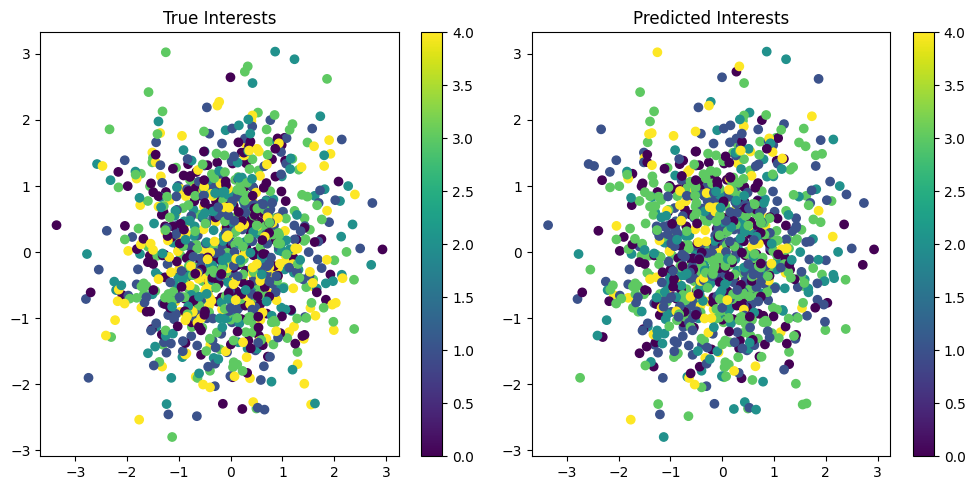

In [4]:
def visualize_predictions(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.title("True Interests")
    plt.scatter(data.x[:, 0], data.x[:, 1], c=data.y, cmap='viridis')
    plt.colorbar()
    
    plt.subplot(122)
    plt.title("Predicted Interests")
    plt.scatter(data.x[:, 0], data.x[:, 1], c=pred, cmap='viridis')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, data)

## Link Prediction

In [7]:
# Define Link Predictor model
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.encoder = GCNConv(in_channels, hidden_channels)
        
    def encode(self, x, edge_index):
        return self.encoder(x, edge_index).relu()
        
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
        
    def forward(self, x, edge_index, edge_label_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index)

# Initialize model and prepare data
model = LinkPredictor(in_channels=num_features, hidden_channels=64)
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False
)

train_data, val_data, test_data = transform(data)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define training function for link prediction
def train_link_predictor():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    pos_edge_index = train_data.edge_index
    neg_edge_index = torch_geometric.utils.negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=pos_edge_index.size(1),
    )

    edge_label_index = torch.cat([
        pos_edge_index, neg_edge_index
    ], dim=-1)
    edge_label = torch.cat([
        torch.ones(pos_edge_index.size(1)),
        torch.zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index)
    loss = torch.nn.BCEWithLogitsLoss()(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss

# Define testing function for link prediction
def test_link_predictor(data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        out = model.decode(z, data.edge_label_index)

    y_true = data.edge_label.cpu().numpy()
    y_pred = out.cpu().numpy()
    return roc_auc_score(y_true, y_pred)

# Training loop
for epoch in range(100):
    loss = train_link_predictor()
    if epoch % 10 == 0:
        val_auc = test_link_predictor(val_data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}')

test_auc = test_link_predictor(test_data)
print(f"Test AUC: {test_auc:.4f}")


# Define friend recommendation function
def recommend_friends(student_id, top_k=5):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        other_students = torch.arange(data.num_nodes)
        other_students = other_students[other_students != student_id]
        edge_index = torch.stack([
            torch.full_like(other_students, student_id),
            other_students
        ])
        scores = model.decode(z, edge_index)
        top_scores, top_indices = scores.topk(top_k)
        recommended_friends = other_students[top_indices]
        return recommended_friends, top_scores

# Example usage
student_id = 42
recommended_friends, scores = recommend_friends(student_id)
print(f"Top 5 friend recommendations for student {student_id}:")
for friend, score in zip(recommended_friends, scores):
    print(f"Student {friend.item()}: Score {score:.4f}")

Epoch: 000, Loss: 0.7254, Val AUC: 0.5381
Epoch: 010, Loss: 0.6782, Val AUC: 0.5096
Epoch: 020, Loss: 0.6719, Val AUC: 0.5061
Epoch: 030, Loss: 0.6672, Val AUC: 0.5149
Epoch: 040, Loss: 0.6664, Val AUC: 0.5233
Epoch: 050, Loss: 0.6647, Val AUC: 0.5190
Epoch: 060, Loss: 0.6644, Val AUC: 0.5220
Epoch: 070, Loss: 0.6623, Val AUC: 0.5256
Epoch: 080, Loss: 0.6599, Val AUC: 0.5218
Epoch: 090, Loss: 0.6622, Val AUC: 0.5128
Test AUC: 0.4700
Top 5 friend recommendations for student 42:
Student 91: Score 1.3606
Student 870: Score 1.1688
Student 851: Score 1.1037
Student 694: Score 1.0145
Student 925: Score 0.9658


## Conclusion

This notebook demonstrated how to implement graph deep learning techniques for social network analysis, including node classification and link prediction tasks. The methods shown here can be adapted for various real-world applications in social network analysis.